**Домашнее задание**

Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime as dt
from datetime import timedelta as tdelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv("aac_shelter_outcomes.csv")
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


Отберем строки для классификации согласно задания.

In [3]:
data = data[data["outcome_type"].isin(["Adoption", "Transfer"])]

Посмотрим на сведения.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56611 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  56609 non-null  object
 1   animal_id         56611 non-null  object
 2   animal_type       56611 non-null  object
 3   breed             56611 non-null  object
 4   color             56611 non-null  object
 5   date_of_birth     56611 non-null  object
 6   datetime          56611 non-null  object
 7   monthyear         56611 non-null  object
 8   name              38660 non-null  object
 9   outcome_subtype   29425 non-null  object
 10  outcome_type      56611 non-null  object
 11  sex_upon_outcome  56611 non-null  object
dtypes: object(12)
memory usage: 5.6+ MB


In [5]:
data.profile_report()

Рассмотрим animal_id.

In [6]:
data["animal_id"].head()

0    A684346
1    A666430
2    A675708
3    A680386
5    A664462
Name: animal_id, dtype: object

Признак animal_id - идентификатор. Для нашей задачи пользы он не несет, но на всякий случай проверим на уникальность.

In [7]:
acnts = data["animal_id"].value_counts()
acnts = acnts[acnts > 1]
print(f'Кол-во неуникальных: {len(acnts)}.')

Кол-во неуникальных: 3352.


Отсортируем по animal_id для наглядности.

In [8]:
data[data["animal_id"].isin(acnts.index)].sort_values(by=["animal_id"])

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
12527,12 years,A282897,Cat,Domestic Shorthair Mix,Black Smoke/White,2001-10-08T00:00:00,2013-12-28T17:05:00,2013-12-28T17:05:00,Toby,NaN,Adoption,Neutered Male
31362,13 years,A282897,Cat,Domestic Shorthair Mix,Black Smoke/White,2001-10-08T00:00:00,2015-07-11T16:49:00,2015-07-11T16:49:00,Toby,NaN,Adoption,Neutered Male
2179,9 years,A378348,Dog,German Shepherd Mix,Black/Brown,2004-08-07T00:00:00,2014-04-23T07:43:00,2014-04-23T07:43:00,Frijolito,Foster,Adoption,Neutered Male
2094,9 years,A378348,Dog,German Shepherd Mix,Black/Brown,2004-08-07T00:00:00,2014-01-19T13:39:00,2014-01-19T13:39:00,Frijolito,NaN,Adoption,Neutered Male
13345,9 years,A390222,Dog,Jack Russell Terrier,White/Tan,2004-05-23T00:00:00,2013-12-15T17:10:00,2013-12-15T17:10:00,Holly,NaN,Adoption,Spayed Female
...,...,...,...,...,...,...,...,...,...,...,...,...
77947,1 year,A765295,Dog,Cairn Terrier Mix,Brown,2017-01-17T00:00:00,2018-01-21T18:03:00,2018-01-21T18:03:00,Max,NaN,Adoption,Neutered Male
77993,10 months,A765350,Cat,Domestic Shorthair Mix,Gray,2017-03-18T00:00:00,2018-01-27T15:51:00,2018-01-27T15:51:00,Luther,NaN,Adoption,Neutered Male
78089,10 months,A765350,Cat,Domestic Shorthair Mix,Gray,2017-03-18T00:00:00,2018-01-29T16:49:00,2018-01-29T16:49:00,Luther,NaN,Adoption,Neutered Male
77961,7 years,A765356,Dog,Beagle Mix,White/Tan,2011-01-18T00:00:00,2018-01-26T15:36:00,2018-01-26T15:36:00,Pete,NaN,Adoption,Neutered Male


Похоже, одно и то же животное попадало в питомник несколько раз. Получается, что предпосылки для результирующей переменной будут разные. Поэтому нет необходимости отсеивать по дублированию id, также, как и группировать значения. Столбец id более не нужен, его можно будет удалить.

Рассмотрим animal_type и breed. Это взаимосвязанные признаки, т.к. порода зависит от того, какое это животное.

In [9]:
data["animal_type"].value_counts()

Dog          29570
Cat          26055
Other          772
Bird           206
Livestock        8
Name: animal_type, dtype: int64

In [10]:
data["breed"].value_counts()

Domestic Shorthair Mix                             20809
Pit Bull Mix                                        3509
Chihuahua Shorthair Mix                             3399
Labrador Retriever Mix                              3258
Domestic Medium Hair Mix                            2049
                                                   ...  
Lhasa Apso/Pekingese                                   1
American Bulldog/American Staffordshire Terrier        1
Australian Shepherd/Parson Russell Terrier             1
Queensland Heeler/Border Collie                        1
Chihuahua Longhair/Cocker Spaniel                      1
Name: breed, Length: 1803, dtype: int64

У породы слишком много различных значений. Модель не сможет обучиться на этом категориальном признаке, поэтому  breed можно будет убрать. Закодируем породу через OneHotEncoder().

In [11]:
ohe = OneHotEncoder(sparse=False)
ohe_f0 = ohe.fit_transform(data[["animal_type"]])
animal_type_res = pd.DataFrame(ohe_f0, index=data.index, columns=["animal_type_" + str(x) for x in ohe.categories_[0]])

Рассмотрим color.

In [12]:
data["color"].value_counts()

Black/White               6111
Black                     5141
Brown Tabby               3975
Brown Tabby/White         2083
Orange Tabby              1914
                          ... 
Apricot/Brown                1
Liver/Chocolate              1
Tricolor/Blue                1
Black Tabby/Gray Tabby       1
Gold/Buff                    1
Name: color, Length: 475, dtype: int64

Как видим, животное может быть одного или нескольких цветов. Посмотрим, какое максимальное кол-во цветов.

In [13]:
def get_color_count(val):
    return len(val.split("/"))

color_counts = data["color"].apply(get_color_count)
print(f"Макс. кол-во цветов: {color_counts.max()}.")

Макс. кол-во цветов: 2.


Разделим цвет на 1-ый и 2-ой, если 2-ого цвета нет, то продублируем 1-ый (так проще будет обрабатывать далее).

In [14]:
def get_color1(val):
    lst = val.split("/")
    return lst[0]

def get_color2(val):
    lst = val.split("/")
    if len(lst) == 2:
        return lst[1]
    else:
        return lst[0]

colors = pd.DataFrame()
colors["color1"] = data["color"].apply(get_color1)
colors["color2"] = data["color"].apply(get_color2)
colors

,color1,color2
0,Orange Tabby,Orange Tabby
1,White,Brown
2,Blue,White
3,White,White
5,Brown,White
...,...,...
78250,Brown,White
78251,Brown,White
78252,Blue,White
78254,Red,Red


Посмотрим как обстоят дела с уникальнойстью цветов.

In [15]:
print(f'Уникальных color1: {len(colors["color1"].unique())}.')
print(f'Уникальных color2: {len(colors["color2"].unique())}.')
print(f'Уникальных при объединении множеств: {len(list(set(np.append(colors["color1"].unique(), colors["color2"].unique()))))}.')

Уникальных color1: 57.
Уникальных color2: 55.
Уникальных при объединении множеств: 57.


Отлично, при объединении множеств получается столько же вариантов, как и вариантов для color1. Значит, мы можем использовать OneHotEncoder, обучив его на color1 и применив на color1 и color2.
Затем объединить результаты простым суммированием датафреймов и заменить значения 2 на 1.
Таким образом, у нас получится OneHotEncoding-преобразование, где в каждой строке будет 1 или 2 единицы.

In [16]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(colors[["color1"]])

ohe_f1 = ohe.transform(colors[["color1"]])
df1 = pd.DataFrame(ohe_f1, index=colors.index, columns=["color_" + str(x) for x in ohe.categories_[0]])

ohe_f2 = ohe.transform(colors[["color2"]])
df2 = pd.DataFrame(ohe_f2, index=colors.index, columns=["color_" + str(x) for x in ohe.categories_[0]])

colors_res = df1.add(df2, fill_value=0).gt(1).astype(np.uint8)
colors_res

,color_Agouti,color_Apricot,color_Black,color_Black Brindle,color_Black Smoke,color_Black Tabby,color_Black Tiger,color_Blue,color_Blue Cream,color_Blue Merle,...,color_Silver Lynx Point,color_Silver Tabby,color_Tan,color_Torbie,color_Tortie,color_Tortie Point,color_Tricolor,color_White,color_Yellow,color_Yellow Brindle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Посмотрим на признаки, связанные с датами и возрастом: age_upon_outcome, date_of_birth, datetime, monthyear.
Значения признаков datetime и monthyear выглядят похожими. Посмотрим насколько они схожи во всем датасете.

In [17]:
print(f'Кол-во различных: {len(data[data["datetime"] != data["monthyear"]])}.')

Кол-во различных: 0.


Выходит, они полностью идентичны, можно будет убрать любой из них.

Судя по всему, age_upon_outcome - это разница между datetime и date_of_birth. Проверим это.

In [18]:
def age_to_days(val): # примерная оценка
    if not isinstance(val, str):
        return -1
    lst = val.split(" ")
    if lst[1][0] == "y":
        k = 365
    elif lst[1][0] == "m":
        k = 30
    elif lst[1][0] == "w":
        k = 7
    elif lst[1][0] == "d":
        k = 1
    else:
        return -1
    return int(lst[0]) * k

def date_to_dt(val):
    return dt.strptime(val, "%Y-%m-%dT%H:%M:%S")

def get_diff(row):
    return (date_to_dt(row["datetime"]) - date_to_dt(row["date_of_birth"])).days


days = data[["date_of_birth", "datetime", "age_upon_outcome"]].copy()
days["age_days"] = data.apply(get_diff, axis=1)
days["age_upon_outcome_days"] = data["age_upon_outcome"].apply(age_to_days)
days

,date_of_birth,datetime,age_upon_outcome,age_days,age_upon_outcome_days
0,2014-07-07T00:00:00,2014-07-22T16:04:00,2 weeks,15,14
1,2012-11-06T00:00:00,2013-11-07T11:47:00,1 year,366,365
2,2013-03-31T00:00:00,2014-06-03T14:20:00,1 year,429,365
3,2005-06-02T00:00:00,2014-06-15T15:50:00,9 years,3300,3285
5,2013-06-03T00:00:00,2013-10-07T13:06:00,4 months,126,120
...,...,...,...,...,...
78250,2017-12-04T00:00:00,2018-02-01T18:40:00,1 month,59,30
78251,2017-12-04T00:00:00,2018-02-01T18:26:00,1 month,59,30
78252,2014-12-30T00:00:00,2018-02-01T18:06:00,3 years,1129,1095
78254,2017-11-13T00:00:00,2018-02-01T18:32:00,2 months,80,60


Посморим разницу между датой рождения и датой выбытия.

In [19]:
days[days["age_days"] < 0]

,date_of_birth,datetime,age_upon_outcome,age_days,age_upon_outcome_days
19814,2014-04-03T00:00:00,2013-12-01T13:19:00,0 years,-123,0
22804,2014-12-12T00:00:00,2014-09-10T17:29:00,0 years,-93,0
45764,2016-11-15T00:00:00,2016-11-05T18:16:00,0 years,-10,0
50533,2015-07-06T00:00:00,2015-07-05T14:46:00,0 years,-1,0
52977,2016-10-28T00:00:00,2016-10-04T15:13:00,0 years,-24,0
64745,2015-08-29T00:00:00,2015-05-24T17:01:00,0 years,-97,0


Видимо, ошибочно введенные данные, таких строк немного, можно удалить.

In [20]:
remove_indexes = days[days["age_days"] < 0].index
days.drop(remove_indexes, inplace=True)

Посмотрим, насколько хорошо преобразовались строки типа "2 weeks" в дни.

In [21]:
days[days["age_upon_outcome_days"] < 0]

,date_of_birth,datetime,age_upon_outcome,age_days,age_upon_outcome_days
77976,2017-01-22T00:00:00,2018-01-25T13:23:00,NaN,368,-1
78162,2017-01-29T00:00:00,2018-01-31T08:14:00,NaN,367,-1


Тоже таких значений не много, можно будет удалить. Для простоты сравнения заменим age_upon_outcome_days из age_days для -1.

In [22]:
days.loc[days["age_upon_outcome_days"] < 0, "age_upon_outcome_days"] = days["age_days"]

Теперь посмотрим насколько сильно age_days и age_upon_outcome_days отклоняются  друг от друга.

In [23]:
days["diff_all_rel"] = (days["age_days"] - days["age_upon_outcome_days"]) / days["age_days"]
print(f'Минимальное отн. отклонение: {days["diff_all_rel"].min()}.')
print(f'Максимальное отн. отклонение: {days["diff_all_rel"].max()}.')
print(f'Строк без отклонений значений: {len(days[days["diff_all_rel"] == days["diff_all_rel"].min()])}.')

Минимальное отн. отклонение: 0.0.
Максимальное отн. отклонение: 0.5081967213114754.
Строк без отклонений значений: 1727.


Как видим age_days близки к age_upon_outcome_days и всегда их превышают. Поэтому их добавим в рабочий датасет, а от всех остальных полей датасета, которые связаны с датой и возрастом, можно будет избавиться.

Посмотрим на выбросы.

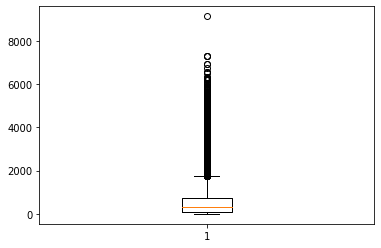

In [24]:
plt.boxplot(days["age_days"]);

Видно, что выбросы - значения более 2000. Посмотрим сколько их с шагом 2000.

In [25]:
print(len(days[days["age_days"] > 2000]))
print(len(days[days["age_days"] > 4000]))
print(len(days[days["age_days"] > 6000]))
print(len(days[days["age_days"] > 8000]))

4655
825
26
1


В принципе, значения более 6000 вполне реальны (16+ лет), но их не так много, и чтобы они не влияли на качество обучения, уберем их.

In [26]:
remove_indexes = remove_indexes.union(days[days["age_days"] > 6000].index)
days.drop(days[days["age_days"] > 6000].index)
days_res = days[["age_days"]]

Вряд ли name нам будет полезен, но все равно посмотрим.

In [27]:
data["name"].value_counts()

Bella           204
Max             169
Luna            158
Daisy           146
Lucy            135
               ... 
*Bahn Mi          1
Melody "Mel"      1
*Coralee          1
115               1
Kissy             1
Name: name, Length: 11989, dtype: int64

Довольно много уникальных значений для name. Пользы для нашей модели мало, признак можно удалить.

Судя по названию outcome_subtype является дополнением к целевой переменной, поэтому мы не можем использвать ее в качестве исходных данных, в добавок к этому, содержит много пропусков, поэтому это поле можно удалить.

Рассмотрим sex_upon_outcome.

In [28]:
data["sex_upon_outcome"].value_counts()

Neutered Male    20732
Spayed Female    19949
Intact Female     6874
Intact Male       6295
Unknown           2761
Name: sex_upon_outcome, dtype: int64

Вариантов значений всего 5, они непорядковые, закодируем через OneHotEncoder().

In [29]:
ohe = OneHotEncoder(sparse=False)
ohe_f2 = ohe.fit_transform(data[["sex_upon_outcome"]])
sex_upon_outcome_res = pd.DataFrame(ohe_f2, index=data.index, columns=["sex_upon_outcome_" + str(x) for x in ohe.categories_[0]])

Соберем всё воедино.

In [30]:
data.drop(columns=["age_upon_outcome", "animal_id", "animal_type", "breed", "color", "date_of_birth", "datetime", "monthyear",
    "name", "outcome_subtype", "sex_upon_outcome"], inplace=True)
data.drop(remove_indexes, inplace=True)
data = data.join(animal_type_res)
data = data.join(days_res)
data = data.join(colors_res)
data = data.join(sex_upon_outcome_res)
data

,outcome_type,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,age_days,color_Agouti,color_Apricot,color_Black,...,color_Tortie Point,color_Tricolor,color_White,color_Yellow,color_Yellow Brindle,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,Transfer,0.0,1.0,0.0,0.0,0.0,15,0,0,0,...,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0
1,Transfer,0.0,0.0,1.0,0.0,0.0,366,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
2,Adoption,0.0,0.0,1.0,0.0,0.0,429,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
3,Transfer,0.0,0.0,1.0,0.0,0.0,3300,0,0,0,...,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0
5,Transfer,0.0,0.0,1.0,0.0,0.0,126,0,0,0,...,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78250,Adoption,0.0,0.0,1.0,0.0,0.0,59,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
78251,Adoption,0.0,0.0,1.0,0.0,0.0,59,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
78252,Adoption,0.0,0.0,1.0,0.0,0.0,1129,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
78254,Adoption,0.0,0.0,1.0,0.0,0.0,80,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0


В PCA нет необходимости для данного датасета, т.к. получившиеся признаки уже довольно независимы друг от друга, кроме того, самих признаков не так много.

Выделим целевую переменную и закодируем ее через LabelEncoder(), чтобы можно было потом использовать данные при построении ROC.

In [31]:
lab = LabelEncoder()
lab_f = lab.fit_transform(data["outcome_type"])
Y = pd.Series(lab_f, name="outcome_type")

Разделим данные на тренировочную выборку и тестовую.

In [32]:
X = data.drop(columns=["outcome_type"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Обучим модель, вычислим качество модели и построим ROC-кривую.

Качество модели на тренировочных данных: 0.8249968438328494.
Качество модели на тестовых данных: 0.8133026982443737.


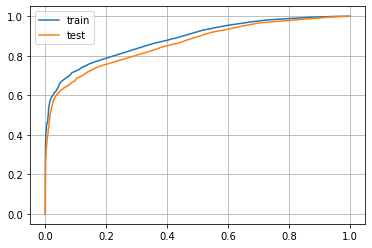

In [33]:
rf = RandomForestClassifier(n_estimators=8, max_depth=13, random_state=42)
rf.fit(X_train, Y_train)
print(f"Качество модели на тренировочных данных: {rf.score(X_train, Y_train)}.")
print(f"Качество модели на тестовых данных: {rf.score(X_test, Y_test)}.")

fpr_train, tpr_train, thres_train = roc_curve(Y_train, rf.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, thres_test = roc_curve(Y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_train, tpr_train, label="train")
plt.plot(fpr_test, tpr_test, label="test")
plt.legend()
plt.grid()
plt.show()